For each dataset (2 HR, 2 SR, 4 SLO):

    - For each model (XLM-R-base, XLM-R-large, CSEBert, SloBERTa, BERTić, multiple versions of XLM-R-BERTić and XLM-R-SloBERTić):


        - fine-tune the model and evaluate it - 5 times

## Setup and Dataset Importing

In [1]:
# Define the gpu on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import evaluate
from datetime import datetime
import pandas as pd
import numpy as np
import json
from simpletransformers.ner import NERModel, NERArgs
from sklearn.metrics import classification_report, f1_score
from tqdm.autonotebook import tqdm as notebook_tqdm
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import logging
import sklearn
from numba import cuda
import argparse
import gc
import torch
import time

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
# Import the dataset

# Code for python script
"""
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("dataset", help="path to the dataset in JSON format")
    args = parser.parse_args()

# Define the path to the dataset
dataset_path = args.dataset
"""
# Define the path to the dataset
dataset_path = "datasets/hr500k.conllup_extracted.json"

# Load the json file
with open(dataset_path, "r") as file:
    json_dict = json.load(file)

# Open the train, eval and test dictionaries as DataFrames
train_df = pd.DataFrame(json_dict["train"])
test_df = pd.DataFrame(json_dict["test"])
dev_df = pd.DataFrame(json_dict["dev"])

# Define the labels
LABELS = json_dict["labels"]
print(LABELS)

print(train_df.shape, test_df.shape, dev_df.shape)
print(train_df.head())


['O', 'B-loc', 'B-org', 'B-per', 'I-per', 'B-deriv-per', 'I-org', 'I-loc', 'B-misc', 'I-misc', 'I-deriv-per']
(398681, 3) (51190, 3) (49764, 3)
    sentence_id      words labels
717  set.hr-s36      Kazna      O
718  set.hr-s36  medijskom      O
719  set.hr-s36     mogulu      O
720  set.hr-s36   obnovila      O
721  set.hr-s36   raspravu      O


## Training code

In [3]:
def train_and_test(model, train_df, test_df, dataset_path):

    # Set up the model's arguments
    model_args = NERArgs()

    # Define the model

    # Define the model arguments - use the same one as for XLM-R-large if model is based on it,
    # if the model is of same size as XLM-R-base, use its optimal hyperparameters (I searched for them before)
    xlm_r_large_args = {"overwrite_output_dir": True,
                "num_train_epochs": 7,
                "labels_list": LABELS,
                "learning_rate": 1e-5,
                "train_batch_size": 32,
                # Comment out no_cache and no_save if you want to save the model
                "no_cache": True,
                "no_save": True,
                "max_seq_length": 256,
                "save_steps": -1,
                "silent": True,
                }

    xlm_r_base_args = {"overwrite_output_dir": True,
             "num_train_epochs": 8,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": 32,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
             "max_seq_length": 256,
             "save_steps": -1,
            "silent": True,
             }


    # Model type - a dictionary of type and model name.
    # To refer to our own models, use the path to the model directory as the model name.
    model_type_dict = {
        "sloberta": ["camembert", "EMBEDDIA/sloberta", xlm_r_base_args],
        "csebert": ["bert", "EMBEDDIA/crosloengual-bert", xlm_r_base_args],
        "xlm-r-base": ["xlmroberta", "xlm-roberta-base", xlm_r_base_args],
        "xlm-r-large": ["xlmroberta", "xlm-roberta-large", xlm_r_large_args],
        "bertic": ["electra", "classla/bcms-bertic", xlm_r_base_args]
    }

    # Update the hyperparameters accordingly to the model
    model_args = model_type_dict[model][2]

    # Experiment with the args - to be deleted later
    # Increase number of epochs - didn't change the scores at all
    # model_args["num_train_epochs"] = 30
    # Decrease learning rate - does not help
    # model_args["learning_rate"] = 1e-6 
    # Increase learning rate - does not help
    #model_args["learning_rate"] = 1e-4
    # Use Nikola's deafault arguments
    model_args["learning_rate"] = 4e-5
    model_args["num_train_epochs"] = 10
    model_args["train_batch_size"] = 8
    model_args["silent"] = False

    # Define the model
    current_model = NERModel(
    model_type_dict[model][0],
    model_type_dict[model][1],
    use_cuda=True,
    args = model_args)

    print("Training started. Current model: {}".format(model))
    print("Model arguments: epochs: {}, learning rate: {}, batch size: {}, max_seq_length: {}".format(model_args["num_train_epochs"], model_args["learning_rate"], model_args["train_batch_size"], model_args["max_seq_length"]))

    start_time = time.time()

    # Fine-tune the model
    current_model.train_model(train_df)

    print("Training completed.")

    training_time = round((time.time() - start_time)/60,2)

    print("It took {} minutes for {} instances.".format(training_time, train_df.shape[0]))

    # Clean cache
    gc.collect()
    torch.cuda.empty_cache()

    start_evaluation_time = time.time()

    # Evaluate the model
    results = current_model.eval_model(test_df)

    print("Evaluation completed.")

    evaluation_time = round((time.time() - start_evaluation_time)/60,2)

    print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))

    # Get predictions
    preds = results[1]

    # Create a list with predictions - my method
    preds_list = []

    for sentence in preds:
        for word in sentence:
            current_word = []
            for element in word:
                # Find prediction with the highest value
                highest_index = element.index(max(element))
                # Transform the index to label
                current_pred = current_model.config.id2label[highest_index]
                # Append to the list
                current_word.append(current_pred)
            # Segmentation can result in multiple predictions for one word - use the first prediction only
            preds_list.append(current_word[0])
    
    run_name = "{}-{}".format(dataset_path, model)

    y_true = test_df.labels.tolist()

    # Evaluate predictions
    metrics = evaluate.testing(y_true, preds_list, list(test_df.labels.unique()), run_name, show_matrix=True)

    # Add y_pred and y_true to the metrics dict
    metrics["y_true_T"] = y_true
    metrics["y_pred_T"] = preds_list

   # Calculate macro F1 with Nikola's/Rik's method as well
    preds_list_N = []

    # Use factorize to convert sentence_id to integer labels
    test_df['sentence_id_f'] = pd.factorize(test_df['sentence_id'])[0]

    preds_N = results[2]
    kept_sentences = 0
    discarded_sentences = 0

    test_df["y_pred_N"] = ""

    # We unfold this list of lists, add it to original test data, and discard 
    # all of the sentences where there is a mismatch.
    for i in test_df.sentence_id_f.unique():
        subset = test_df[test_df.sentence_id_f == i]
        if subset.shape[0] == len(preds_N[i]):
            test_df.loc[test_df.sentence_id_f == i, "y_pred_N"] = preds_N[i]
            kept_sentences += 1
        else:
            discarded_sentences += 1
            continue

    test_df_N = test_df[test_df.y_pred_N != ""]
    y_true_N = test_df_N.labels.tolist()
    y_pred_N = test_df_N.y_pred_N.tolist()

    labels_N = list(test_df_N.labels.unique())

    print("Number of kept and discarded sentences; percentage of discarded sentences:")
    print(kept_sentences)
    print(discarded_sentences)
    print(discarded_sentences/(kept_sentences+discarded_sentences)*100)

    macrof1_N = f1_score(y_true_N, y_pred_N, labels=labels_N, average='macro')
    microf1_N = f1_score(y_true_N, y_pred_N, labels=labels_N, average='micro')
    clfreport = classification_report(y_true_N, y_pred_N, labels=labels_N)

    # Let's also add entire results
    metrics["results_output"] = results

    # Let's add Nikola's results
    metrics["Micro F1 Nikola"] = microf1_N
    metrics["Macro F1 Nikola"] = macrof1_N

    print("Nikola's Macro F1: {} and Micro F1: {}".format(macrof1_N, microf1_N))
    
    # The function returns a dict with accuracy, micro f1, macro f1, y_true and y_pred
    return metrics

In [ ]:
# Create a new file for results
#with open("ner-results-testing.txt", "w") as file:
#    file.write("Date\tModel\tRun\tDataset\tMicro F1\tMacro F1\tMicro F1 Nikola\t Macro F1 Nikola\tLabel Report\n")

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training started. Current model: xlm-r-base
Model arguments: epochs: 10, learning rate: 4e-05, batch size: 8, max_seq_length: 256


INFO:simpletransformers.ner.ner_model: Converting to features started.


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Running Epoch 0 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 1 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 2 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/2474 [00:00<?, ?it/s]

INFO:simpletransformers.ner.ner_model: Training of xlmroberta model complete. Saved to outputs/.
INFO:simpletransformers.ner.ner_model: Converting to features started.


Training completed.
It took 23.6 minutes for 398681 instances.


  0%|          | 0/5 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/311 [00:00<?, ?it/s]

INFO:simpletransformers.ner.ner_model:{'eval_loss': 0.10031254514321526, 'precision': 0.8746189024390244, 'recall': 0.8857583944423003, 'f1_score': 0.8801534036433365}


Evaluation completed.
It took 0.26 minutes for 51190 instances.
Macro f1: 0.0982, Micro f1: 0.84
Accuracy: 0.84


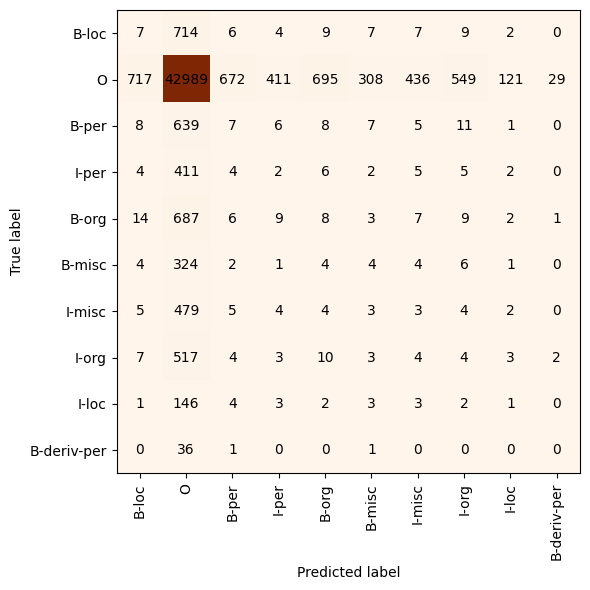

Number of kept and discarded sentences; percentage of discarded sentences:
60
2426
97.58648431214803
Nikola's Macro F1: 0.10343270099367659 and Micro F1: 0.8703087885985749
Run Nikola-default-args finished.


/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/NER-recognition/ner/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 640x480 with 0 Axes>

In [4]:
# Testing the models if they work as expected
# models: ["xlm-r-large", "sloberta", "csebert", "xlm-r-base", "bertic"]
model = "xlm-r-base"
run = "Nikola-default-args"

current_results_dict = train_and_test(model, train_df, test_df, dataset_path)

# Add to the dict model name, dataset name and run
current_results_dict["model"] = model
current_results_dict["run"] = "{}-{}".format(model, run)
current_results_dict["dataset"] = dataset_path

# Add to the file with results all important information
with open("ner-results-testing.txt", "a") as file:
    file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["Micro F1 Nikola"], current_results_dict["Macro F1 Nikola"], current_results_dict["label-report"]))

# Add to the original test_df y_preds
#test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

# Save entire dict just in case
#with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
#    json.dump(current_results_dict, backlog, indent=2)

print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
#test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))

In [5]:
# Inspect results
results_df = pd.read_csv("ner-results-testing.txt", sep="\t")

results_df

,Date,Model,Run,Dataset,Micro F1,Macro F1,Micro F1 Nikola,Macro F1 Nikola,Label Report
0,17/08/2023 08:51:20,xlm-r-base,xlm-r-base-testing xlm-r-base,datasets/hr500k.conllup_extracted.json,0.839422,0.096976,0.864198,0.103069,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
1,17/08/2023 09:15:52,xlm-r-base,xlm-r-base-testing xlm-r-base,datasets/hr500k.conllup_extracted.json,0.839344,0.097316,0.863248,0.103009,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
2,17/08/2023 10:03:24,xlm-r-base,xlm-r-base-epochs-to-30,datasets/hr500k.conllup_extracted.json,0.839070,0.097772,0.867047,0.103251,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
3,17/08/2023 10:17:52,xlm-r-base,xlm-r-base-lr-to-1e-6,datasets/hr500k.conllup_extracted.json,0.839383,0.096620,0.861349,0.102992,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
4,17/08/2023 10:28:55,xlm-r-base,xlm-r-base-lr-to-1e-4,datasets/hr500k.conllup_extracted.json,0.839910,0.097347,0.870845,0.128229,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."
5,17/08/2023 11:07:01,xlm-r-base,xlm-r-base-Nikola-default-args,datasets/hr500k.conllup_extracted.json,0.840496,0.098157,0.870309,0.103433,"{'B-deriv-per': {'precision': 0.0, 'recall': 0..."


## Run models

In [ ]:
#For each model, repeat training and testing 5 times - let's do 2 times for starters
model_list = ["xlm-r-large", "sloberta", "csebert", "xlm-r-base", "bertic"]

for model in model_list:
    for run in list(range(2)):
        current_results_dict = train_and_test(model, train_df, test_df, dataset_path)

        # Add to the dict model name, dataset name and run
        current_results_dict["model"] = model
        current_results_dict["run"] = "{}-{}".format(model, run)
        current_results_dict["dataset"] = dataset_path

        # Add to the file with results all important information
        with open("ner-results.txt", "a") as file:
            file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["label-report"]))

        # Add to the original test_df y_preds
        test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

        # Save entire dict just in case
        with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
            json.dump(current_results_dict, backlog, indent=2)
    
        print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))

In [ ]:
# Use factorize to convert sentence_id to integer labels
test_df['sentence_id'] = pd.factorize(test_df['sentence_id'])[0]

test_df.head(20)


In [ ]:
from sklearn.metrics import classification_report, f1_score

predictions = results[2]
kept_sentences = 0
discarded_sentences = 0

test_df["y_pred"] = ""

 # We unfold this list of lists, add it to original test data, and discard 
# all of the sentences where  there is a mismatch.
for i in test_df.sentence_id.unique():
    subset = test_df[test_df.sentence_id == i]
    if subset.shape[0] == len(predictions[i]):
        test_df.loc[test_df.sentence_id == i, "y_pred"] = predictions[i]
        kept_sentences += 1
    else:
        discarded_sentences += 1
        continue

test_df = test_df[test_df.y_pred != ""]
y_true = test_df.labels.tolist()
y_pred = test_df.y_pred.tolist()

labels = list(test_df.labels.unique())

print(len(y_true))
print(kept_sentences)
print(discarded_sentences)

#print(y_true,y_pred)
macrof1 = f1_score(y_true, y_pred, labels=labels, average='macro')
microf1 = f1_score(y_true, y_pred, labels=labels, average='micro')
clfreport = classification_report(y_true, y_pred, labels=labels)
print(str(microf1)+'\t'+str(macrof1))

In [ ]:
def train_and_test(model, train_df, test_df):

    # Set up the model's arguments
    model_args = NERArgs()

    # Define the model

    # Define the model arguments - use the same one as for XLM-R-large if model is based on it,
    # if the model is of same size as XLM-R-base, use its optimal hyperparameters (I searched for them before)
    xlm_r_large_args = {"overwrite_output_dir": True,
                "num_train_epochs": 7,
                "labels_list": LABELS,
                "learning_rate": 1e-5,
                "train_batch_size": 32,
                # Comment out no_cache and no_save if you want to save the model
                "no_cache": True,
                "no_save": True,
                "max_seq_length": 256,
                "save_steps": -1,
                "wandb_project": "NER",
                "silent": True,
                }

    xlm_r_base_args = {"overwrite_output_dir": True,
             "num_train_epochs": 8,
             "labels_list": LABELS,
             "learning_rate": 1e-5,
             "train_batch_size": 32,
             # Comment out no_cache and no_save if you want to save the model
             "no_cache": True,
             "no_save": True,
             "max_seq_length": 256,
             "save_steps": -1,
            "wandb_project": "NER",
            "silent": True,
             }


    # Model type - a dictionary of type and model name.
    # To refer to our own models, use the path to the model directory as the model name.
    model_type_dict = {
        "sloberta": ["camembert", "EMBEDDIA/sloberta", xlm_r_base_args],
        "csebert": ["bert", "EMBEDDIA/crosloengual-bert", xlm_r_base_args],
        "xlm-r-base": ["xlmroberta", "xlm-roberta-base", xlm_r_base_args],
        "xlm-r-large": ["xlmroberta", "xlm-roberta-large", xlm_r_large_args],
        "bertic": ["electra", "classla/bcms-bertic", xlm_r_base_args]
    }

    # Update the hyperparameters accordingly to the model
    model_args = model_type_dict[model][2]

    # Define the model
    current_model = NERModel(
    model_type_dict[model][0],
    model_type_dict[model][1],
    use_cuda=True,
    args = model_args)

    print("Training started. Current model: {}".format(model))
    start_time = time.time()

    # Fine-tune the model
    current_model.train_model(train_df)

    print("Training completed.")

    training_time = round((time.time() - start_time)/60,2)

    print("It took {} minutes for {} instances.".format(training_time, train_df.shape[0]))

    # Clean cache
    gc.collect()
    torch.cuda.empty_cache()

    start_evaluation_time = time.time()

    # Evaluate the model
    results = current_model.eval_model(test_df)

    print("Evaluation completed.")

    evaluation_time = round((time.time() - start_evaluation_time)/60,2)

    print("It took {} minutes for {} instances.".format(evaluation_time, test_df.shape[0]))

    # Get predictions
    preds = results[1]

    # Create a list with predictions
    preds_list = []

    for sentence in preds:
        for word in sentence:
            current_word = []
            for element in word:
                # Find prediction with the highest value
                highest_index = element.index(max(element))
                # Transform the index to label
                current_pred = current_model.config.id2label[highest_index]
                # Append to the list
                current_word.append(current_pred)
            # Segmentation can result in multiple predictions for one word - use the first prediction only
            preds_list.append(current_word[0])
    
    # Get y_true
    y_true = list(test_df.labels)

    # Evaluate predictions
    metrics = evaluate.testing(y_true, preds_list, list(test_df.labels.unique()), show_matrix=True)

    # Add y_pred and y_true to the metrics dict
    metrics["y_true"] = y_true
    metrics["y_pred"] = preds_list
    
    # The function returns a dict with accuracy, micro f1, macro f1, y_true and y_pred
    return metrics

In [ ]:
# Create a file with results
with open("ner-results.txt", "w") as file:
    file.write("Date\tModel\tRun\tDataset\tMicro F1\tMacro F1\tLabel Report\n")

In [ ]:
# For each model, repeat training and testing 5 times
model_list = ["xlm-r-large"]

for model in model_list:
    for run in list(range(5)):
        current_results_dict = train_and_test(model, train_df, test_df)

        # Add to the dict model name, dataset name and run
        current_results_dict["model"] = model
        current_results_dict["run"] = "{}-{}".format(model, run)
        current_results_dict["dataset"] = dataset_path

        # Add to the file with results all important information
        with open("ner-results.txt", "a") as file:
            file.write("{}\t{}\t{}\t{}\t{}\t{}\t{}\n".format(datetime.now().strftime("%d/%m/%Y %H:%M:%S"), current_results_dict["model"], current_results_dict["run"], current_results_dict["dataset"], current_results_dict["micro F1"], current_results_dict["macro F1"], current_results_dict["label-report"]))

        # Add to the original test_df y_preds
        test_df["y_pred_{}_{}".format(model, run)] = current_results_dict["y_pred"]

        # Save entire dict just in case
        with open("{}-{}-{}-backlog.json".format(dataset_path,model,run), "w") as backlog:
            json.dump(current_results_dict, backlog, indent=2)
    
        print("Run {} finished.".format(run))

# At the end, save the test_df with all predictions
test_df.to_csv("{}-test_df-with-predictions.csv".format(dataset_path))

# Result Analysis

In [ ]:
# Import the txt with results
import pandas as pd

results = pd.read_csv("ner-results.txt", sep="\t")

results

In [ ]:
# Get average micro and macro F1
import matplotlib as plt
results.groupby("Model")["Micro F1"].mean().plot(kind="bar", color="blue")
results.groupby("Model")["Macro F1"].mean().plot(kind="bar", color="orange")

In [ ]:
pred_df.columns

In [ ]:
# Let's analyze the df with all the predictions
import numpy as np

pred_df = pd.read_csv("datasets/hr500k.conllup_extracted.json-test_df-with-predictions.csv", index_col = 0)

# Analyze instances where models are wrong
pred_df["match"] = np.where(pred_df["labels"] != pred_df["y_pred_xlm-r-large_0"], "no", "yes")
pred_df.match.value_counts()

In [ ]:
pred_df[pred_df["match"] == "no"]

## Undersampled dataset

In [ ]:
import json

In [ ]:
# Let's try creating a new dataset with O values undersampled by removing sentences that have no named entity

with open("datasets/hr500k.conllup_extracted.json", "r") as file:
    dataset = json.load(file)

train_d = dataset["train"]
train_df = pd.DataFrame(train_d)

train_df

In [ ]:
list(train_df.labels.unique())

In [ ]:
train_df.head(30)

In [ ]:
train_df["NER"] = "yes"
meaningful_s = []
meaningless_s = 0

for i in list(train_df.sentence_id.unique()):
    label_list = list(train_df[train_df.sentence_id == i].labels.unique())
    if len(label_list) > 1:
        meaningful_s.append(i)
    elif "O" not in label_list:
        meaningful_s.append(i)

meaningful_s

In [ ]:
# Number of meaningful s: 8966, compared to all s (19791)
8966/19791*100

In [ ]:
# Let's create a separate train file of only meaningful s
undersampled_train_df = train_df[train_df["sentence_id"].isin(meaningful_s)]

undersampled_train_df.head()

In [ ]:
train_df.describe()

In [ ]:
train_df.labels.value_counts(normalize=True)

In [ ]:
undersampled_train_df.describe()

In [ ]:
undersampled_train_df.labels.value_counts(normalize=True)

In [ ]:
# Save undersampled train
undersampled_train_df.to_csv("datasets/hr500k.conllup_extracted.json_undersampled_train.csv")